<a href="https://colab.research.google.com/github/DCEG-workshops/statgen_workshop_tutorial/blob/main/src/02_qc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up a few things

In [1]:
#load python libraries
import os

In [2]:
#load R magic
%load_ext rpy2.ipython

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
#take a look at the files
%ls drive/MyDrive/statgen_workshop/data/workshop1/inputs/penncath_withPheno/

causal_variants.txt  penncath.bim  plink_fix.log  run_plink.sh   sim_pheno.phen
gcta_sim.log         penncath.fam  run_gcta.log   sim_pheno.log
penncath.bed         penncath.log  run_gcta.sh    sim_pheno.par


In [13]:
#take a look at my path
%%bash
echo $PATH
ls /tools/node/bin
touch /tools/node/bin/test.txt
ls /tools/node/bin

/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
node
npm
npx
test.txt
node
npm
npx
test.txt


In [21]:
#download plink1.9
%%bash
curl -o /tools/node/bin/plink.zip https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20230116.zip
cd /tools/node/bin/
unzip plink.zip

Archive:  plink.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8743k  100 8743k    0     0  3340k      0  0:00:02  0:00:02 --:--:-- 3339k


In [40]:
#see if we can execute plink
%%bash
plink --help

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3

In the command line flag definitions that follow,
  * <angle brackets> denote a required parameter, where the text between the
    angle brackets describes its nature.
  * ['square brackets + single-quotes'] denotes an optional modifier.  Use the
    EXACT text in the quotes.
  * [{bar|separated|braced|bracketed|values}] denotes a collection of mutually
    exclusive optional modifiers (again, the exact text must be used).  When
    there are no outer square brackets, one of the choices must be selected.
  * ['quoted_text='<description of value>] denotes an optional modifier that
    must begin with the quoted text, and be followed by a value with no
    whitespace in between.  '|' may also be used here to indicate mutually
    exclusive options.
  * [square brackets without quotes or braces] denote an optional parameter,
    whe

In [39]:
#set variables
input_dir="drive/MyDrive/statgen_workshop/data/workshop1/inputs/penncath_withPheno"
analysis_dir=os.getcwd() + "/analysis/"
os.environ['input_dir']=input_dir
os.environ['analysis_dir']=analysis_dir

In [43]:
#create analysis dir, this is going to be ephemeral and sits on the hosted runtime environment
mkdir -p ${analysis_dir}

load R libraries

In [30]:
%%R -i input_dir -i analysis_dir
library(tidyverse)
library(data.table)
library(glue)

print(input_dir)
print(analysis_dir)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘data.table’



    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year



    between, first, last



    transpose




[1] "drive/MyDrive/statgen_workshop/data/workshop1/inputs/penncath_withPheno"
[1] "/content/analysis/"


# QC steps

Calculate call rates for flagging poorly called SNPs and individuals
the penncath.lmss file shows the per variant missingness and the penncath.imiss file shows the per individual missingness

In [44]:
%%bash -s "$analysis_dir" "$input_dir"
plink --bfile ${input_dir}/penncath --missing --out ${analysis_dir}/penncath

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.log.
Options in effect:
  --bfile drive/MyDrive/statgen_workshop/data/workshop1/inputs/penncath_withPheno/penncath
  --missing
  --out /content/analysis//penncath

12982 MB RAM detected; reserving 6491 MB for main workspace.
861473 variants loaded from .bim file.
1401 people (937 males, 464 females) loaded from .fam.
933 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1401 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%

let's look at the distribution of per variant call rates   

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


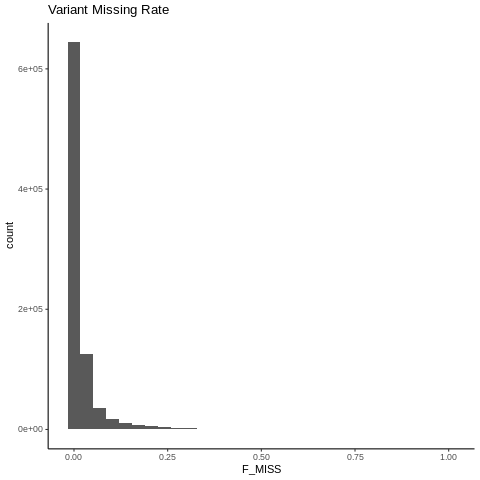

In [45]:
%%R
variant_miss <- fread(glue(analysis_dir, "penncath.lmiss"))

variant_miss %>% ggplot( aes(x = F_MISS)) +
  geom_histogram() +
  labs(title = "Variant Missing Rate") +
  theme_classic()

If we want to filter out the variants with missing rate >0.01, how many are there?

In [46]:
%%R
variant_miss %>% mutate(missing_rate_gt0.01 = if_else(F_MISS > 0.01, "Yes", "No")) %>%
                 group_by(missing_rate_gt0.01) %>%
                 tally()

# A tibble: 2 × 2
  missing_rate_gt0.01      n
  <chr>                <int>
1 No                  569723
2 Yes                 291750


We will use plink to filter out the 291750 SNPs and

In [47]:
%%bash
plink --bfile ${input_dir}/penncath --geno 0.01 --make-bed --out ${analysis_dir}/penncath.geno0.01

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.log.
Options in effect:
  --bfile drive/MyDrive/statgen_workshop/data/workshop1/inputs/penncath_withPheno/penncath
  --geno 0.01
  --make-bed
  --out /content/analysis//penncath.geno0.01

12982 MB RAM detected; reserving 6491 MB for main workspace.
861473 variants loaded from .bim file.
1401 people (937 males, 464 females) loaded from .fam.
933 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1401 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45

After removing the 291750 SNPs, we will recalculate the missing rate for the samples

In [48]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01 --missing --out ${analysis_dir}/penncath.geno0.01

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01
  --missing
  --out /content/analysis//penncath.geno0.01

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1401 people (937 males, 464 females) loaded from .fam.
933 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1401 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%5

take a look at per sample missing rate

In [49]:
%%R
sample_miss <- fread(glue(analysis_dir, "penncath.geno0.01.imiss"))
sample_miss %>% mutate(missing_rate_gt0.01 = if_else(F_MISS > 0.01, "Yes", "No")) %>%
                 group_by(missing_rate_gt0.01) %>%
                 tally()

# A tibble: 2 × 2
  missing_rate_gt0.01     n
  <chr>               <int>
1 No                   1380
2 Yes                    21


we will remove the 21 samples with >0.01 missing rate

In [50]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01 --mind 0.01 --make-bed --out ${analysis_dir}/penncath.geno0.01.mind0.01

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01
  --make-bed
  --mind 0.01
  --out /content/analysis//penncath.geno0.01.mind0.01

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1401 people (937 males, 464 females) loaded from .fam.
933 phenotype values loaded from .fam.
21 people removed due to missing genotype data (--mind).
IDs written to /content/analysis//penncath.geno0.01.mind0.01.irem .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%

Next, we look at the HWE statistics

In [52]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01 --hardy --out ${analysis_dir}/penncath.geno0.01.mind0.01

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --hardy
  --out /content/analysis//penncath.geno0.01.mind0.01

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%

Examine HWE statistics

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


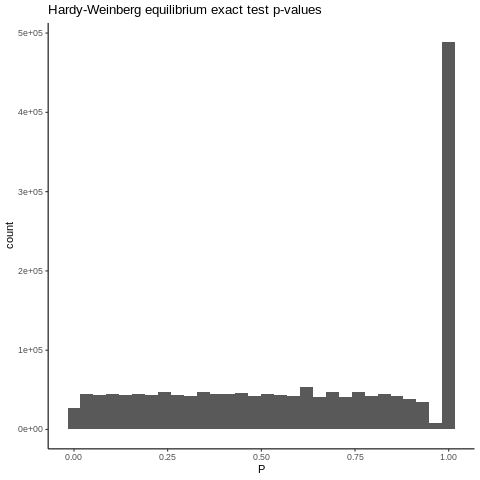

In [53]:
%%R
hwe_stat <- fread(glue(analysis_dir, "penncath.geno0.01.mind0.01.hwe"))


hwe_stat %>% ggplot( aes(x = P)) +
  geom_histogram() +
  labs(title = "Hardy-Weinberg equilibrium exact test p-values") +
  theme_classic()

How many markers are with P<1e-8?
TODO: what threshold to use????

In [54]:
%%R
hwe_stat %>% mutate(hwe_stat_lessThan1e_8 = if_else(P < 1e-8, TRUE, FALSE)) %>%
                 group_by(hwe_stat_lessThan1e_8) %>%
                 tally()

# A tibble: 2 × 2
  hwe_stat_lessThan1e_8       n
  <lgl>                   <int>
1 FALSE                 1708443
2 TRUE                      726


LD pruning

In [55]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01 --indep-pairwise 50 5 0.3 --out ${analysis_dir}/penncath.geno0.01.mind0.01

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --indep-pairwise 50 5 0.3
  --out /content/analysis//penncath.geno0.01.mind0.01

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%

Relatedness check

In [56]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01 \
      --extract ${analysis_dir}/penncath.geno0.01.mind0.01.prune.in \
      --genome --min 0.05 --out ${analysis_dir}/penncath.geno0.01.mind0.01.LD0.3

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.LD0.3.log.
Options in effect:
  --bfile /content/analysis///penncath.geno0.01.mind0.01
  --extract /content/analysis//penncath.geno0.01.mind0.01.prune.in
  --genome
  --min 0.05
  --out /content/analysis//penncath.geno0.01.mind0.01.LD0.3

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
--extract: 176206 variants remaining.
Using up to 2 threads (change this with --threads).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%

Check pairs of samples with PI_HAT>0.05, maximum PI_HAT is 0.1745, no duplicates nor first degree relatives
TODO: do we want to remove any samples?

In [57]:
%%R
ibd <- fread(glue(analysis_dir, "penncath.geno0.01.mind0.01.LD0.3.genome"))
summary(ibd$PI_HAT)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05000 0.05225 0.05395 0.06848 0.05962 0.17450 


run Heterozygocity

In [59]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01 --het \
      --extract ${analysis_dir}/penncath.geno0.01.mind0.01.prune.in \
      --out ${analysis_dir}/penncath.geno0.01.mind0.01.LD0.3

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.LD0.3.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --extract /content/analysis//penncath.geno0.01.mind0.01.prune.in
  --het
  --out /content/analysis//penncath.geno0.01.mind0.01.LD0.3

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
--extract: 176206 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%

look at the heterozygocity of individuals, find individuals with heterozygocity +- 3 s.d.
TODO: remove any one?

In [60]:
%%R
heterozygocity <- fread(glue(analysis_dir, "penncath.geno0.01.mind0.01.LD0.3.het"))

heterozygocity %>% mutate (het_rate = (`N(NM)` - `O(HOM)`) / `N(NM)` ) %>%
                   ggplot( aes(x = het_rate)) +
                   geom_histogram() +
                   labs(title = "Heterozygocity") +
                   theme_classic()

heterozygocity %>% mutate (het_rate = (`N(NM)` - `O(HOM)`) / `N(NM)` ) %>%
                   filter (het_rate < mean(het_rate)-3*sd(het_rate) |
                          het_rate > mean(het_rate)+3*sd(het_rate))

      FID IID O(HOM) E(HOM)  N(NM)        F  het_rate
 1: 10063   1 135070 136300 175538 -0.03105 0.2305370
 2: 10312   1 134247 135600 174626 -0.03475 0.2312313
 3: 10386   1 133933 135400 174490 -0.03681 0.2324317
 4: 10420   1 133492 135300 174257 -0.04522 0.2339361
 5: 10675   1 133848 135300 174286 -0.03779 0.2320209
 6: 10986   1 137896 136400 175638  0.03909 0.2148852
 7: 11232   1 135362 136600 175908 -0.03114 0.2304955
 8: 11310   1 134242 135500 174565 -0.03295 0.2309913
 9: 11315   1 135452 136700 176066 -0.03182 0.2306749
10: 11455   1 138068 136600 175997  0.03639 0.2155094
11: 11594   1 133948 135300 174422 -0.03472 0.2320464


use plink for simple pca

In [62]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01  \
      --extract ${analysis_dir}/penncath.geno0.01.mind0.01.prune.in \
      --maf 0.05 --pca  --out ${analysis_dir}/penncath.geno0.01.mind0.01.LD0.3

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.LD0.3.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --extract /content/analysis//penncath.geno0.01.mind0.01.prune.in
  --maf 0.05
  --out /content/analysis//penncath.geno0.01.mind0.01.LD0.3
  --pca

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
--extract: 176206 variants remaining.
Using up to 2 threads (change this with --threads).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30

plot PCA

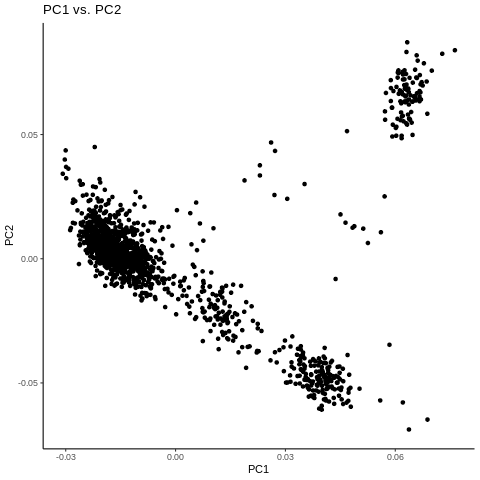

In [64]:
%%R
pca <- fread(glue(analysis_dir, "penncath.geno0.01.mind0.01.LD0.3.eigenvec"))

pca %>% rename (PC1 = V3, PC2 = V4) %>%
        ggplot(aes(x = PC1, y = PC2)) +
        geom_point() +
        labs(title = "PC1 vs. PC2") + theme_classic()

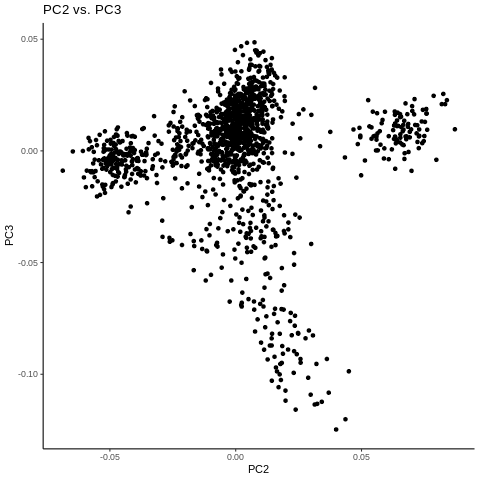

In [65]:
%%R
pca %>% rename (PC2 = V4, PC3 = V5) %>%
        ggplot(aes(x = PC2, y = PC3)) +
        geom_point() +
        labs(title = "PC2 vs. PC3") + theme_classic()